In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 22 17:38:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Importing Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/My Drive/HAR

/content/drive/My Drive/HAR


In [5]:
%ls 

HAR_CNN_AE_LSTM.ipynb        t-sne_perp_20_iter_1000.png
HAR_EDA.ipynb                t-sne_perp_2_iter_1000.png
HAR_PREDICTION_MODELS.ipynb  t-sne_perp_50_iter_1000.png
model_plot.png               t-sne_perp_5_iter_1000.png
t-sne_perp_10_iter_1000.png  UCI_HAR_Dataset/


In [6]:
import pandas as pd
import numpy as np

In [7]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [8]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [9]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [10]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [11]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [12]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [13]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [14]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [15]:
# Import Keras
from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [16]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [17]:
# Initializing parameters
epochs = 200
batch_size = 128

In [18]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [19]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [20]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(X_train.shape)

128
9
7352
(7352, 128, 9)


In [21]:

# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
n_features = input_dim
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [22]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters

#Convolutional AE


model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(
            filters=64, kernel_size=3,strides=2,
            activation="relu",
            input_shape=(n_length, n_features)
        )
    )
)

model.add(
    tf.keras.layers.TimeDistributed(
      tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
    )
)



model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1DTranspose(
            filters=64, kernel_size=3,strides=2,
            activation="relu"
        )
    )
)


model.add(
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Flatten()
    ) 
)

model.add(Dropout(0.5))

model.add(LSTM(64))


# Adding a dense layer with relu activation
model.add(Dense(64, activation='relu'))

# Adding a dense layer with relu activation
model.add(Dense(64, activation='relu'))

model.add(Dense(n_classes, activation='softmax'))

# model.summary()

In [23]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

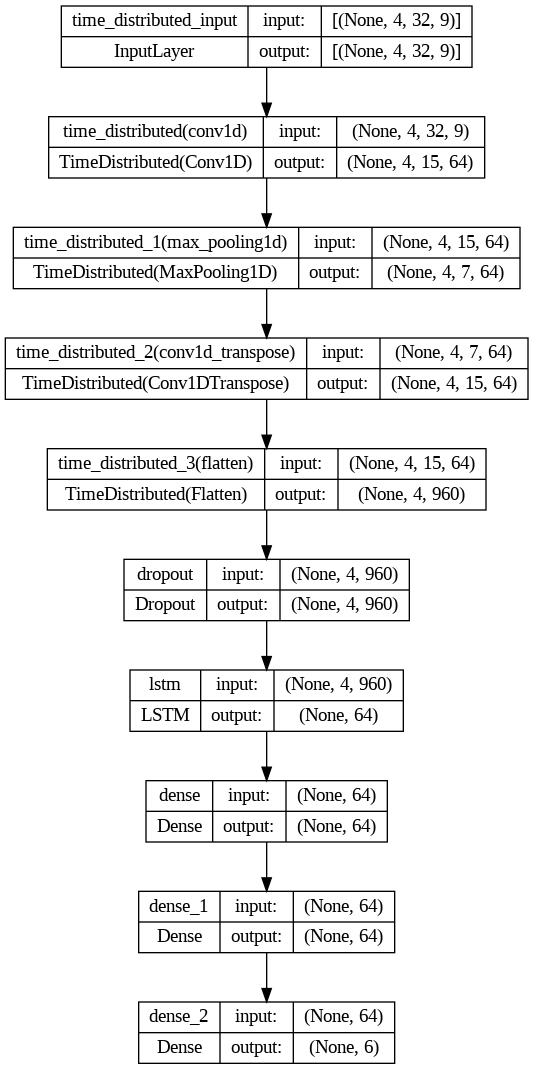

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/200
58/58 [==============================] - 12s 18ms/step - loss: 0.8111 - accuracy: 0.6836 - val_loss: 0.6221 - val_accuracy: 0.7363
Epoch 2/200
58/58 [==============================] - 1s 9ms/step - loss: 0.3410 - accuracy: 0.8649 - val_loss: 0.5221 - val_accuracy: 0.8164
Epoch 3/200
58/58 [==============================] - 0s 7ms/step - loss: 0.2190 - accuracy: 0.9140 - val_loss: 0.4262 - val_accuracy: 0.8480
Epoch 4/200
58/58 [==============================] - 0s 7ms/step - loss: 0.1635 - accuracy: 0.9344 - val_loss: 0.5160 - val_accuracy: 0.8341
Epoch 5/200
58/58 [==============================] - 0s 7ms/step - loss: 0.1396 - accuracy: 0.9433 - val_loss: 0.4118 - val_accuracy: 0.8843
Epoch 6/200
58/58 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.9483 - val_loss: 0.4031 - val_accuracy: 0.8826
Epoch 7/200
58/58 [==============================] - 0s 7ms/step - loss: 0.1151 - accuracy: 0.9528 - val_loss: 0.4665 - val_accuracy: 0.8839
Epoch 8/200

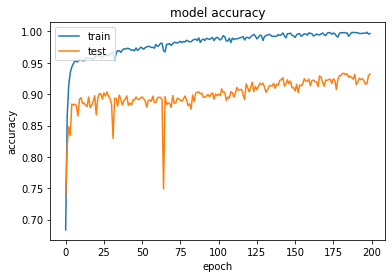

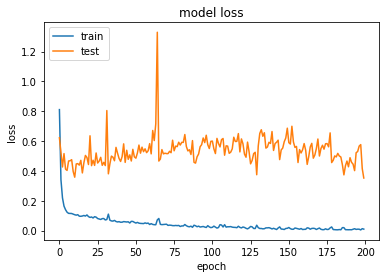

In [24]:
#Training the model

history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=200)


import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

93/93 [==============================] - 1s 2ms/step
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 521        0         0        0                   0   
SITTING                  3      415        72        0                   0   
STANDING                 0       52       476        0                   0   
WALKING                  0        0         0      472                  24   
WALKING_DOWNSTAIRS       0        0         0       10                 409   
WALKING_UPSTAIRS         0        0         0        1                  16   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            16  
SITTING                            1  
STANDING                           4  
WALKING                            0  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 454  
93/93 [===

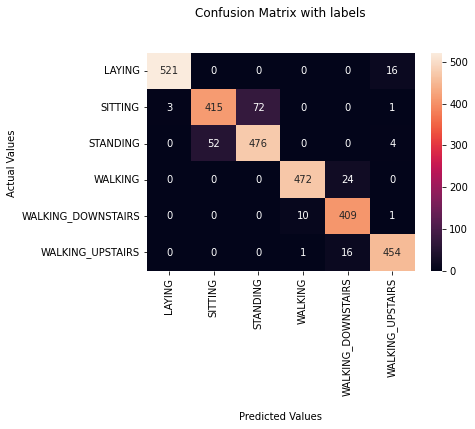

In [26]:
#Confusion Matrix

print(confusion_matrix(Y_test, model.predict(X_test)))
cf_matrix = confusion_matrix(Y_test, model.predict(X_test))

import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix, annot=True, cmap='rocket',fmt='g')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['LAYING','SITTING','STANDING', 'WALKING' ,'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])
ax.yaxis.set_ticklabels(['LAYING','SITTING','STANDING', 'WALKING' ,'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])

# Display the visualization of the Confusion Matrix.
plt.show()

In [27]:
score = model.evaluate(X_test, Y_test)

93/93 [==============================] - 1s 6ms/step - loss: 0.3522 - accuracy: 0.9321


In [28]:
score

[0.35219526290893555, 0.9321343898773193]

In [29]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:

from datetime import datetime
import sklearn.metrics as metrics
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    # Training the model
    model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=np.argmax(y_test,axis=1), y_pred=np.argmax(y_pred,axis=1))
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))

    # confusion matrix
    cm = metrics.confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    

Epoch 1/200
58/58 [==============================] - 1s 10ms/step - loss: 0.0072 - accuracy: 0.9969 - val_loss: 0.4788 - val_accuracy: 0.9199
Epoch 2/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.5199 - val_accuracy: 0.9179
Epoch 3/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.5082 - val_accuracy: 0.9213
Epoch 4/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.4782 - val_accuracy: 0.9277
Epoch 5/200
58/58 [==============================] - 0s 8ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.4270 - val_accuracy: 0.9223
Epoch 6/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.4927 - val_accuracy: 0.9196
Epoch 7/200
58/58 [==============================] - 0s 7ms/step - loss: 0.0061 - accuracy: 0.9974 - val_loss: 0.4529 - val_accuracy: 0.9267
Epoch 8/200


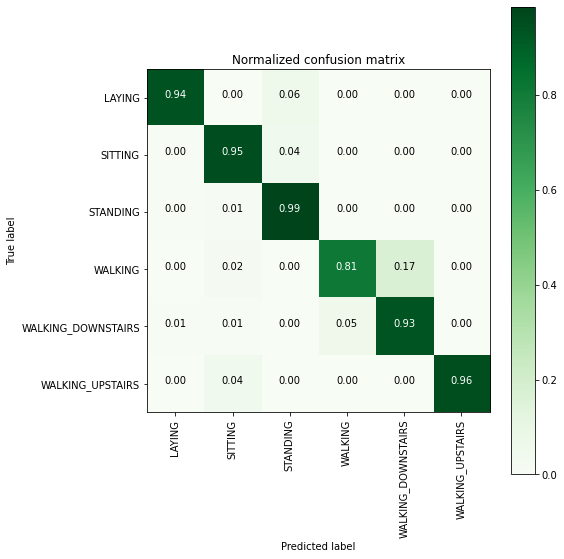

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       496
           1       0.91      0.95      0.93       471
           2       0.89      0.99      0.94       420
           3       0.93      0.81      0.87       491
           4       0.86      0.93      0.89       532
           5       1.00      0.96      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [31]:
class_labels = ['LAYING','SITTING','STANDING', 'WALKING' ,'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
model_results = perform_model(model, X_train, Y_train, X_test, Y_test, class_labels)


In [ ]:
EPOCHS=500

import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

kf = KFold(5, shuffle=True, random_state=42) 
    
oos_y = []
oos_pred = []
fold = 0
x = X_train
y = Y_train

# Must specify y StratifiedKFold for
for train, test in kf.split(x):  
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    model = Sequential()

    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(
                filters=128, kernel_size=6,strides=2,
                activation="relu",
                input_shape=(n_length, n_features)
            )
        )
    )

    model.add(
        tf.keras.layers.TimeDistributed(
          tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        )
    )



    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1DTranspose(
                filters=128, kernel_size=6,strides=2,
                activation="relu"
            )
        )
    )


    model.add(
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Flatten()
        ) 
    )

    model.add(Dropout(0.5))

    model.add(LSTM(64))


    # Adding a dense layer with relu activation
    model.add(Dense(64, activation='relu'))

    # Adding a dense layer with relu activation
    model.add(Dense(64, activation='relu'))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(x_train,y_train, batch_size=128, validation_data=(x_test,y_test),verbose=1,
              epochs=EPOCHS)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)    

    # Measure this fold's accuracy
    score = model.evaluate(x_test,y_test)
    print(f"Fold score (Accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = metrics.accuracy_score(np.argmax(oos_pred,axis=1),np.argmax(oos_y,axis=1))
print(f"Final, out of sample score (Accuracy): {score}")    
    


Streaming output truncated to the last 5000 lines.
Epoch 11/500
46/46 [==============================] - 0s 9ms/step - loss: 0.0969 - accuracy: 0.9582 - val_loss: 0.0887 - val_accuracy: 0.9633
Epoch 12/500
46/46 [==============================] - 0s 8ms/step - loss: 0.0911 - accuracy: 0.9578 - val_loss: 0.0811 - val_accuracy: 0.9606
Epoch 13/500
46/46 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9628 - val_loss: 0.0768 - val_accuracy: 0.9640
Epoch 14/500
46/46 [==============================] - 0s 9ms/step - loss: 0.0892 - accuracy: 0.9619 - val_loss: 0.0845 - val_accuracy: 0.9592
Epoch 15/500
46/46 [==============================] - 0s 8ms/step - loss: 0.0753 - accuracy: 0.9631 - val_loss: 0.0724 - val_accuracy: 0.9633
Epoch 16/500
46/46 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.9645 - val_loss: 0.0699 - val_accuracy: 0.9646
Epoch 17/500
46/46 [==============================] - 0s 8ms/step - loss: 0.0753 - accuracy: 0.96